## Consensus cell typing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import colorcet as cc

from synapse_utils import io

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
repo_root = '../..'
checkpoint_path = '../../output/checkpoint__synapseclr__so3__second_stage'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

# these are pre-computed (can be set to None)
contamination_indices_path = os.path.join(
    checkpoint_path, 'indices', 'contamination_meta_df_row_indices.npy')
reload_epoch = 99
node_idx_list = [0, 1, 2, 3]

# synapse to neurite map
pni_synapses_csv_path = '../../tables/pni_synapses_v185.csv'

# censored imputation data path
censored_imputation_path = '../../output/gp/synapse_simclr_consensus'
pct_annotation_list = [5, 4, 3, 2, 1]
censor_fraction_list = [0.156, 0.325, 0.494, 0.663, 0.831]
rng_seed_list = [40, 41, 42, 43, 45, 46, 47, 48, 49, 50]
imputed_filename_schema = 'imputed_meta__rbf__100__c={0:.3f}__s={1:d}.csv'
censored_filename_schema = 'censored_meta_ext__rbf__100__c={0:.3f}__s={1:d}.csv'

# uncensored imputation data
uncensored_imputation_path = '../../output/gp/synapse_simclr_production'
uncensored_imputed_filename = 'imputed_meta__rbf__synapse_simclr__ensemble.csv'

# output path
output_path = '../../output/consensus'

## Helper functions

In [7]:
def get_row_indices_from_synapse_ids(synapse_ids, meta_df):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

## Load

In [8]:
# load synapse metadata
_, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook='encoder.fc',
    dataset_path=dataset_path,
    l2_normalize=False,
    contamination_indices_path=contamination_indices_path)

# all synapse IDs that we want to consensus call
included_synapse_ids = meta_df['synapse_id'].values
included_synapse_ids_set = set(included_synapse_ids)

annotated_synapse_ids = meta_ext_df['synapse_id'].values
annotated_synapse_ids_set = set(annotated_synapse_ids)

In [9]:
# Load neurite information
pni_synapses_df = pd.read_csv(pni_synapses_csv_path, index_col=None)

## Generate hash tables

In [10]:
from collections import defaultdict

root_id_to_pre_synapse_id_list_map = defaultdict(list)
root_id_to_post_synapse_id_list_map = defaultdict(list)
synapse_id_to_pre_root_id_map = dict()
synapse_id_to_post_root_id_map = dict()

for synapse_id, pre_root_id, post_root_id in zip(
        pni_synapses_df['id'].values,
        pni_synapses_df['pre_root_id'].values,
        pni_synapses_df['post_root_id'].values):
    
    # drop the synapse if is not in our set
    if synapse_id not in included_synapse_ids_set:
        continue
        
    root_id_to_pre_synapse_id_list_map[pre_root_id].append(synapse_id)
    root_id_to_post_synapse_id_list_map[post_root_id].append(synapse_id)
    synapse_id_to_pre_root_id_map[synapse_id] = pre_root_id
    synapse_id_to_post_root_id_map[synapse_id] = post_root_id

## Generate consensus cell type calls

In [11]:
def generate_consensus_cell_type_df(
        imputed_meta_df: pd.DataFrame,
        eps: float = 1e-8):

    # generate hash tables
    synapse_id_to_pre_cell_type_log_prob_0_map = {
        synapse_id: v for synapse_id, v in zip(
            imputed_meta_df['synapse_id'].values,
            np.log(eps + imputed_meta_df['imputed__pre_cell_type__class_0']).values)}

    synapse_id_to_pre_cell_type_log_prob_1_map = {
        synapse_id: v for synapse_id, v in zip(
            imputed_meta_df['synapse_id'].values,
            np.log(eps + imputed_meta_df['imputed__pre_cell_type__class_1']).values)}

    synapse_id_to_post_cell_type_log_prob_0_map = {
        synapse_id: v for synapse_id, v in zip(
            imputed_meta_df['synapse_id'].values,
            np.log(eps + imputed_meta_df['imputed__post_cell_type__class_0']).values)}

    synapse_id_to_post_cell_type_log_prob_1_map = {
        synapse_id: v for synapse_id, v in zip(
            imputed_meta_df['synapse_id'].values,
            np.log(eps + imputed_meta_df['imputed__post_cell_type__class_1']).values)}

    # first, we consensus-type each root
    root_ids_set = set(root_id_to_pre_synapse_id_list_map.keys()).union(
        set(root_id_to_post_synapse_id_list_map.keys()))
    root_id_to_n_synapses_map = dict()

    root_id_log_prob_sum_map = dict()
    for root_id in root_ids_set:
        log_prob_sum_0 = 0.
        log_prob_sum_1 = 0.
        n = 0
        for synapse_id in root_id_to_pre_synapse_id_list_map[root_id]:
            log_prob_sum_0 += synapse_id_to_pre_cell_type_log_prob_0_map[synapse_id]
            log_prob_sum_1 += synapse_id_to_pre_cell_type_log_prob_1_map[synapse_id]
            n += 1
        for synapse_id in root_id_to_post_synapse_id_list_map[root_id]:
            log_prob_sum_0 += synapse_id_to_post_cell_type_log_prob_0_map[synapse_id]
            log_prob_sum_1 += synapse_id_to_post_cell_type_log_prob_1_map[synapse_id]
            n += 1
        root_id_log_prob_sum_map[root_id] = [log_prob_sum_0, log_prob_sum_1]
        root_id_to_n_synapses_map[root_id] = n

    root_id_to_consensus_cell_type_map = {
        root_id: np.argmax(log_prob_sum)
        for root_id, log_prob_sum in root_id_log_prob_sum_map.items()}

    # next, we propagate the root consensus cell type to the synapses
    single_pre_cell_type_list = []
    single_post_cell_type_list = []
    consensus_pre_cell_type_list = []
    consensus_post_cell_type_list = []
    consensus_pre_n_synapses = []
    consensus_post_n_synapses = []
    
    for synapse_id in included_synapse_ids:

        pre_root_id = synapse_id_to_pre_root_id_map[synapse_id]
        post_root_id = synapse_id_to_post_root_id_map[synapse_id]
        consensus_pre_cell_type = root_id_to_consensus_cell_type_map[pre_root_id]
        consensus_post_cell_type = root_id_to_consensus_cell_type_map[post_root_id]
        single_pre_cell_type = int(synapse_id_to_pre_cell_type_log_prob_1_map[synapse_id] > np.log(0.5))
        single_post_cell_type = int(synapse_id_to_post_cell_type_log_prob_1_map[synapse_id] > np.log(0.5))
        pre_root_n_synapses = root_id_to_n_synapses_map[pre_root_id]
        post_root_n_synapses = root_id_to_n_synapses_map[post_root_id]

        single_pre_cell_type_list.append(single_pre_cell_type)
        single_post_cell_type_list.append(single_post_cell_type)
        consensus_pre_cell_type_list.append(consensus_pre_cell_type)
        consensus_post_cell_type_list.append(consensus_post_cell_type)
        consensus_pre_n_synapses.append(pre_root_n_synapses)
        consensus_post_n_synapses.append(post_root_n_synapses)

    # generate dataframe
    consensus_cell_type_df = pd.DataFrame(dict(
        synapse_id=included_synapse_ids,
        pre_cell_type__consensus=consensus_pre_cell_type_list,
        post_cell_type__consensus=consensus_post_cell_type_list,
        pre_cell_type__single=single_pre_cell_type_list,
        post_cell_type__single=single_post_cell_type_list,
        pre_cell_type__consensus__n_synapses=consensus_pre_n_synapses,
        post_cell_type__consensus__n_synapses=consensus_post_n_synapses))
    
    return consensus_cell_type_df

In [12]:
for censor_fraction in censor_fraction_list:
    for rng_seed in rng_seed_list:
        
        print(f'{censor_fraction}, {rng_seed} ...')

        # load imputed cell type probs
        imputed_meta_df = pd.read_csv(
            os.path.join(
                censored_imputation_path,
                imputed_filename_schema.format(censor_fraction, rng_seed)),
            index_col=0)

        # generate consensus calls
        consensus_meta_df = generate_consensus_cell_type_df(imputed_meta_df)
        
        # save
        consensus_meta_df.to_csv(
            os.path.join(output_path, f'consensus__meta__c={censor_fraction:.3f}__s={rng_seed:d}.csv'))

0.156, 40 ...
0.156, 41 ...
0.156, 42 ...
0.156, 43 ...
0.156, 45 ...
0.156, 46 ...
0.156, 47 ...
0.156, 48 ...
0.156, 49 ...
0.156, 50 ...
0.325, 40 ...
0.325, 41 ...
0.325, 42 ...
0.325, 43 ...
0.325, 45 ...
0.325, 46 ...
0.325, 47 ...
0.325, 48 ...
0.325, 49 ...
0.325, 50 ...
0.494, 40 ...
0.494, 41 ...
0.494, 42 ...
0.494, 43 ...
0.494, 45 ...
0.494, 46 ...
0.494, 47 ...
0.494, 48 ...
0.494, 49 ...
0.494, 50 ...
0.663, 40 ...
0.663, 41 ...
0.663, 42 ...
0.663, 43 ...
0.663, 45 ...
0.663, 46 ...
0.663, 47 ...
0.663, 48 ...
0.663, 49 ...
0.663, 50 ...
0.831, 40 ...
0.831, 41 ...
0.831, 42 ...
0.831, 43 ...
0.831, 45 ...
0.831, 46 ...
0.831, 47 ...
0.831, 48 ...
0.831, 49 ...
0.831, 50 ...


## Evaluation

In [13]:
# generate the full-dataset root-synapse map
root_id_to_pre_synapse_id_list_full_map = defaultdict(list)
root_id_to_post_synapse_id_list_full_map = defaultdict(list)

for synapse_id, pre_root_id, post_root_id in zip(
        pni_synapses_df['id'].values,
        pni_synapses_df['pre_root_id'].values,
        pni_synapses_df['post_root_id'].values):

#     # drop the synapse if is not in our set
#     if synapse_id not in included_synapse_ids_set:
#         continue
        
    root_id_to_pre_synapse_id_list_full_map[pre_root_id].append(synapse_id)
    root_id_to_post_synapse_id_list_full_map[post_root_id].append(synapse_id)

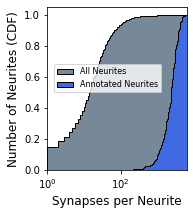

In [14]:
# plot distribution of number of synapses per neurite
root_ids_set = set(root_id_to_pre_synapse_id_list_map.keys()).union(
    set(root_id_to_post_synapse_id_list_map.keys()))
root_id_to_n_synapses_map = dict()
for root_id in root_ids_set:
    n = (len(root_id_to_pre_synapse_id_list_full_map[root_id]) +
         len(root_id_to_post_synapse_id_list_full_map[root_id]))
    root_id_to_n_synapses_map[root_id] = n
    
# all root ids encountered in the annotated synapses
annotated_root_ids_set = set(map(synapse_id_to_pre_root_id_map.get, annotated_synapse_ids)).union(
    set(map(synapse_id_to_post_root_id_map.get, annotated_synapse_ids)))

n_synapse_per_neurite_all = list(root_id_to_n_synapses_map.values())
n_synapse_per_neurite_annotated = list(map(root_id_to_n_synapses_map.get, annotated_root_ids_set))

fig, ax = plt.subplots(figsize=(2.5, 3.0))

ax.hist(n_synapse_per_neurite_all,
        bins=np.logspace(0., np.log10(np.max(n_synapse_per_neurite_all)), 200, base=10.),
        cumulative=True,
        density=True,
        log=False,
        color='lightslategray',
        histtype='stepfilled',
        edgecolor='black',
        label='All Neurites');

ax.hist(n_synapse_per_neurite_annotated,
        bins=np.logspace(0., np.log10(np.max(n_synapse_per_neurite_all)), 200, base=10.),
        cumulative=True,
        density=True,
        log=False,
        color='royalblue',
        histtype='stepfilled',
        edgecolor='black',
        label='Annotated Neurites');

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(title=None, bbox_to_anchor=(0.05, 0.65), loc=2, borderaxespad=0., fontsize=8)
# for key, (interval, color) in synapse_per_neurite_strata.items():    
#     ax.axvspan(interval[0], min(interval[1], max(v)), alpha=0.3, color=color)


ax.set_ylabel('Number of Neurites (CDF)')
ax.set_xlabel('Synapses per Neurite')
ax.set_xlim((min(n_synapse_per_neurite_all), max(n_synapse_per_neurite_all)))

fig.savefig('../../output/consensus/neurite_n_syapses_hist.pdf', bbox_inches='tight')

## Generate evaluation metrics

In [15]:
synapse_per_neurite_strata = {
    'Consensus (SpN $\in [1, 20]$)': ([1, 20], 'deeppink'),
    'Consensus (SpN $\in [21, 50]$)': ([21, 50], 'deeppink'),
    'Consensus (SpN $\geq 51$)': ([51, np.inf], 'green'),
    'Consensus (All)': ([1, np.inf], 'green'),
}

In [16]:
validation_pct_annotation_list = []
validation_rng_seed_list = []
validation_modality_list = []
validation_polarity_list = []
validation_label_list = []
validation_inclusion_mask_list = []
validation_cell_type_list = []
validation_accuracy_list = []
validation_error_list = []
validation_n_total = []

for censor_fraction, pct_annotation in zip(censor_fraction_list, pct_annotation_list):
    
    for rng_seed in rng_seed_list:
        
        print(f'{censor_fraction}, {rng_seed} ...')
        
        # load consensus
        consensus_meta_df = pd.read_csv(
            os.path.join(output_path, f'consensus__meta__c={censor_fraction:.3f}__s={rng_seed:d}.csv'),
            index_col=0)
        consensus_meta_df.set_index('synapse_id', inplace=True)
        
        # load censored annotations
        censored_meta_df = pd.read_csv(
            os.path.join(
                censored_imputation_path,
                censored_filename_schema.format(censor_fraction, rng_seed)),
            index_col=0)
        
        # subset to censored
        consensus_meta_df = consensus_meta_df.loc[censored_meta_df['synapse_id'].values]
        
        # validate!
        
        n_total_validation_synapses = len(censored_meta_df)

        for modality in ['consensus', 'single']:
            
            for polarity in ['pre', 'post']:

                inclusion_mask_dict = dict()
                # inclusion_mask_dict['all'] = np.ones((n_total_validation_synapses,), dtype=bool)
                if modality == 'consensus':
                    for stratum_key, (interval, _) in synapse_per_neurite_strata.items():
                        inclusion_mask_dict[stratum_key] = (
                            (consensus_meta_df[f'{polarity}_cell_type__consensus__n_synapses'].values >= interval[0]) &
                            (consensus_meta_df[f'{polarity}_cell_type__consensus__n_synapses'].values <= interval[1]))
                else:
                    inclusion_mask_dict['Single Synapse'] = np.ones((n_total_validation_synapses,), dtype=bool)

                for cell_type_key, cell_type in zip(['ex', 'in'], [0, 1]):

                    actual_mask = (censored_meta_df[f'{polarity}_cell_type'].values == cell_type)
                    pred_mask = (consensus_meta_df[f'{polarity}_cell_type__{modality}'].values == cell_type)

                    for inclusion_mask_key, inclusion_mask in inclusion_mask_dict.items():

                        n = np.sum(actual_mask & inclusion_mask)
                        if n > 0:
                            acc = (1e-8 + np.sum(actual_mask & pred_mask & inclusion_mask)) / (1e-8 + n)
                            err = (1e-8 + np.sum(actual_mask & (~pred_mask) & inclusion_mask)) / (1e-8 + n)
                        else:
                            acc = np.nan
                            err = np.nan

                        # generate label
                        
                        
                        # append
                        validation_pct_annotation_list.append(pct_annotation)
                        validation_rng_seed_list.append(rng_seed)
                        validation_modality_list.append(modality)
                        validation_polarity_list.append(polarity)
                        validation_inclusion_mask_list.append(inclusion_mask_key)
                        validation_cell_type_list.append(cell_type_key)
                        validation_accuracy_list.append(acc)
                        validation_error_list.append(err)
                        validation_n_total.append(n)

0.156, 40 ...
0.156, 41 ...
0.156, 42 ...
0.156, 43 ...
0.156, 45 ...
0.156, 46 ...
0.156, 47 ...
0.156, 48 ...
0.156, 49 ...
0.156, 50 ...
0.325, 40 ...
0.325, 41 ...
0.325, 42 ...
0.325, 43 ...
0.325, 45 ...
0.325, 46 ...
0.325, 47 ...
0.325, 48 ...
0.325, 49 ...
0.325, 50 ...
0.494, 40 ...
0.494, 41 ...
0.494, 42 ...
0.494, 43 ...
0.494, 45 ...
0.494, 46 ...
0.494, 47 ...
0.494, 48 ...
0.494, 49 ...
0.494, 50 ...
0.663, 40 ...
0.663, 41 ...
0.663, 42 ...
0.663, 43 ...
0.663, 45 ...
0.663, 46 ...
0.663, 47 ...
0.663, 48 ...
0.663, 49 ...
0.663, 50 ...
0.831, 40 ...
0.831, 41 ...
0.831, 42 ...
0.831, 43 ...
0.831, 45 ...
0.831, 46 ...
0.831, 47 ...
0.831, 48 ...
0.831, 49 ...
0.831, 50 ...


In [17]:
validation_df = pd.DataFrame(dict(
    pct_annotation=validation_pct_annotation_list,
    rng_seed=validation_rng_seed_list,
    modality=validation_modality_list,
    polarity=validation_polarity_list,
    stratum=validation_inclusion_mask_list,
    n_total=validation_n_total,
    cell_type=validation_cell_type_list,
    accuracy=validation_accuracy_list,
    error=validation_error_list))

In [18]:
pd.set_option('display.max_rows', 50)
validation_df

,pct_annotation,rng_seed,modality,polarity,stratum,n_total,cell_type,accuracy,error
0,5,40,consensus,pre,"Consensus (SpN $\in [1, 20]$)",0,ex,NaN,NaN
1,5,40,consensus,pre,"Consensus (SpN $\in [21, 50]$)",5,ex,1.000000,2.000000e-09
2,5,40,consensus,pre,Consensus (SpN $\geq 51$),426,ex,1.000000,2.347418e-11
3,5,40,consensus,pre,Consensus (All),431,ex,1.000000,2.320186e-11
4,5,40,consensus,pre,"Consensus (SpN $\in [1, 20]$)",1,in,1.000000,1.000000e-08
...,...,...,...,...,...,...,...,...,...
995,1,50,consensus,post,Consensus (All),927,in,1.000000,1.078749e-11
996,1,50,single,pre,Single Synapse,2267,ex,0.898544,1.014557e-01
997,1,50,single,pre,Single Synapse,2408,in,0.885797,1.142027e-01
998,1,50,single,post,Single Synapse,3748,ex,0.867930,1.320704e-01


## Plots

In [20]:
import seaborn as sns

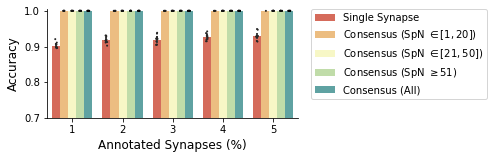

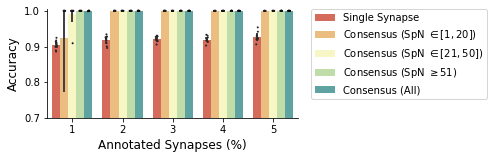

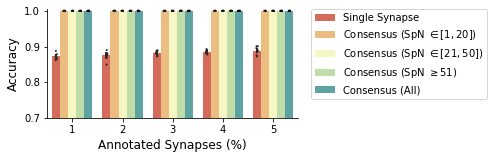

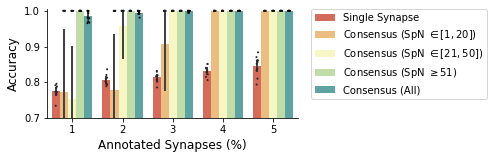

In [22]:
for polarity in ['pre', 'post']:
    for cell_type in ['ex', 'in']:

        _validation_df = validation_df[(validation_df['polarity'] == polarity) & (validation_df['cell_type'] == cell_type)].copy()

        fig, ax = plt.subplots(figsize=(4.5, 2))
        
        sns.barplot(
            x=_validation_df['pct_annotation'],
            y=_validation_df['accuracy'],
            hue=_validation_df['stratum'],
            palette='Spectral',
            hue_order=['Single Synapse'] + list(synapse_per_neurite_strata.keys()),
            ax=ax,
            errwidth=2.)

        # we are adding '_' to strata to suppress their appearance in the legend
        _validation_df['stratum'] = ['_' + v for v in _validation_df['stratum']]
        sns.stripplot(
            x=_validation_df['pct_annotation'],
            y=_validation_df['accuracy'],
            hue=_validation_df['stratum'],
            size=2, linewidth=0,
            color='black',
            hue_order=['_Single Synapse'] + ['_' + v for v in synapse_per_neurite_strata.keys()],
            ax=ax,
            dodge=True,
            label='_nolegend_')

        plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        ax.set_ylim((0.7, 1.005))
        ax.set_xlabel('Annotated Synapses (%)')
        ax.set_ylabel('Accuracy')
        sns.despine(trim=False, left=False)

        fig.savefig(f'../../output/consensus/evaluation__{polarity}__{cell_type}.pdf', bbox_inches='tight')

## Generate consensus from the fully annotated set

In [24]:
# load imputed cell type probs
imputed_meta_df = pd.read_csv(
    os.path.join(
        uncensored_imputation_path,
        uncensored_imputed_filename),
    index_col=0)

# generate consensus calls
consensus_meta_df = generate_consensus_cell_type_df(imputed_meta_df)

# save
consensus_meta_df.to_csv(
    os.path.join(output_path, f'consensus__meta__uncensored.csv'))

## Estimate mean consensus accuracy (lower bound)

Using a binomial model.

In [25]:
# let's take our worst single-synapse cell type accuracy (inhibitory post-synaptic) 
p_single_lower_bound = np.mean(validation_df[
    (validation_df['modality'] == 'single') &
    (validation_df['cell_type'] == 'in') &
    (validation_df['polarity'] == 'post') &
    (validation_df['pct_annotation'] == 5)]['accuracy'].values)
print(p_single_lower_bound)

0.8459445987539137


In [26]:
import scipy.stats as stats

p_neurite_success_list = []
for i, n in enumerate(n_synapse_per_neurite_all):
    p_neurite_success = 1. - stats.binom.cdf(n=n, p=p_single_lower_bound, k=n // 2)
    p_neurite_success_list.append(p_neurite_success)
    if i % 10_000 == 0:
        print(i)
p_neurite_success_list = np.asarray(p_neurite_success_list)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [27]:
n_synapse_per_neurite_all = np.asarray(n_synapse_per_neurite_all)
approx_mean_accuracy = np.sum(p_neurite_success_list * n_synapse_per_neurite_all) / np.sum(n_synapse_per_neurite_all)

In [28]:
approx_mean_accuracy

0.9978541385580922

Using our "worst" estimate of single-synapse cell typing accuracy, the mean cell typing accuracy of a neurite is ~ 0.998